In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import sys
sys.path.append("/home/ahmet/deep-active-learning-2")

/home/ahmet/deep-active-learning-2


In [54]:
# import pandas as pd
# import os
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from datasets import DatasetDict, Dataset

# df = pd.read_csv("data/KPN_DAM_data.csv", index_col=0)
# df = df.drop(columns=['order', 'segments', 'actor_id'])
# df['dialogue_acts'] = df['dialogue_acts'].apply(lambda x: x.strip("[]"))
# le = LabelEncoder()
# df['label'] = le.fit_transform(df['dialogue_acts'])
# df = df.groupby("conversation_id").agg(list)
# total_length = lambda text_list: sum([len(text) for text in text_list])
# df = df[df['text'].apply(total_length) / 4 < 4000]
# train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
# print(train_data.shape, test_data.shape)

# train_dataset = Dataset.from_pandas(train_data)
# test_dataset = Dataset.from_pandas(test_data)
# dataset_dict = DatasetDict({"train": train_dataset, "test": test_dataset})

# os.makedirs("data/kpn", exist_ok=True)
# dataset_dict.save_to_disk("data/kpn")

(2159, 3) (240, 3)


Saving the dataset (0/1 shards):   0%|          | 0/2159 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/240 [00:00<?, ? examples/s]

skipped dialogue: 20201123_144709_VGFS
skipped dialogue: 20201123_160912_VVHO
skipped dialogue: 20201124_090327_FWOE
skipped dialogue: 20201125_093410_BPEO
skipped dialogue: 20201125_132329_DCVH
skipped dialogue: 20201126_105947_GIJC
skipped dialogue: 20201126_132023_PYDD
skipped dialogue: 20201127_092954_JXNB
skipped dialogue: 20201127_112519_TJIK
skipped dialogue: 20201127_135933_UKCH
skipped dialogue: 20201130_132946_BHGL
skipped dialogue: 20201130_173351_UFLX
skipped dialogue: 20201201_113529_WFJG
skipped dialogue: 20201201_125345_WSZV
skipped dialogue: 20201201_142015_XHVZ
skipped dialogue: 20201202_163100_KWZO
skipped dialogue: 20201202_191056_CTFV
skipped dialogue: 20201203_134442_FBKV
skipped dialogue: 20201203_135516_FDHD
skipped dialogue: 20201203_144307_FLJT
skipped dialogue: 20201203_150302_FOTR
skipped dialogue: 20201204_115314_IEJE
skipped dialogue: 20201204_163213_SMZT
skipped dialogue: 20201206_160940_MNEQ
skipped dialogue: 20201208_101234_ROVI
skipped dialogue: 2020120

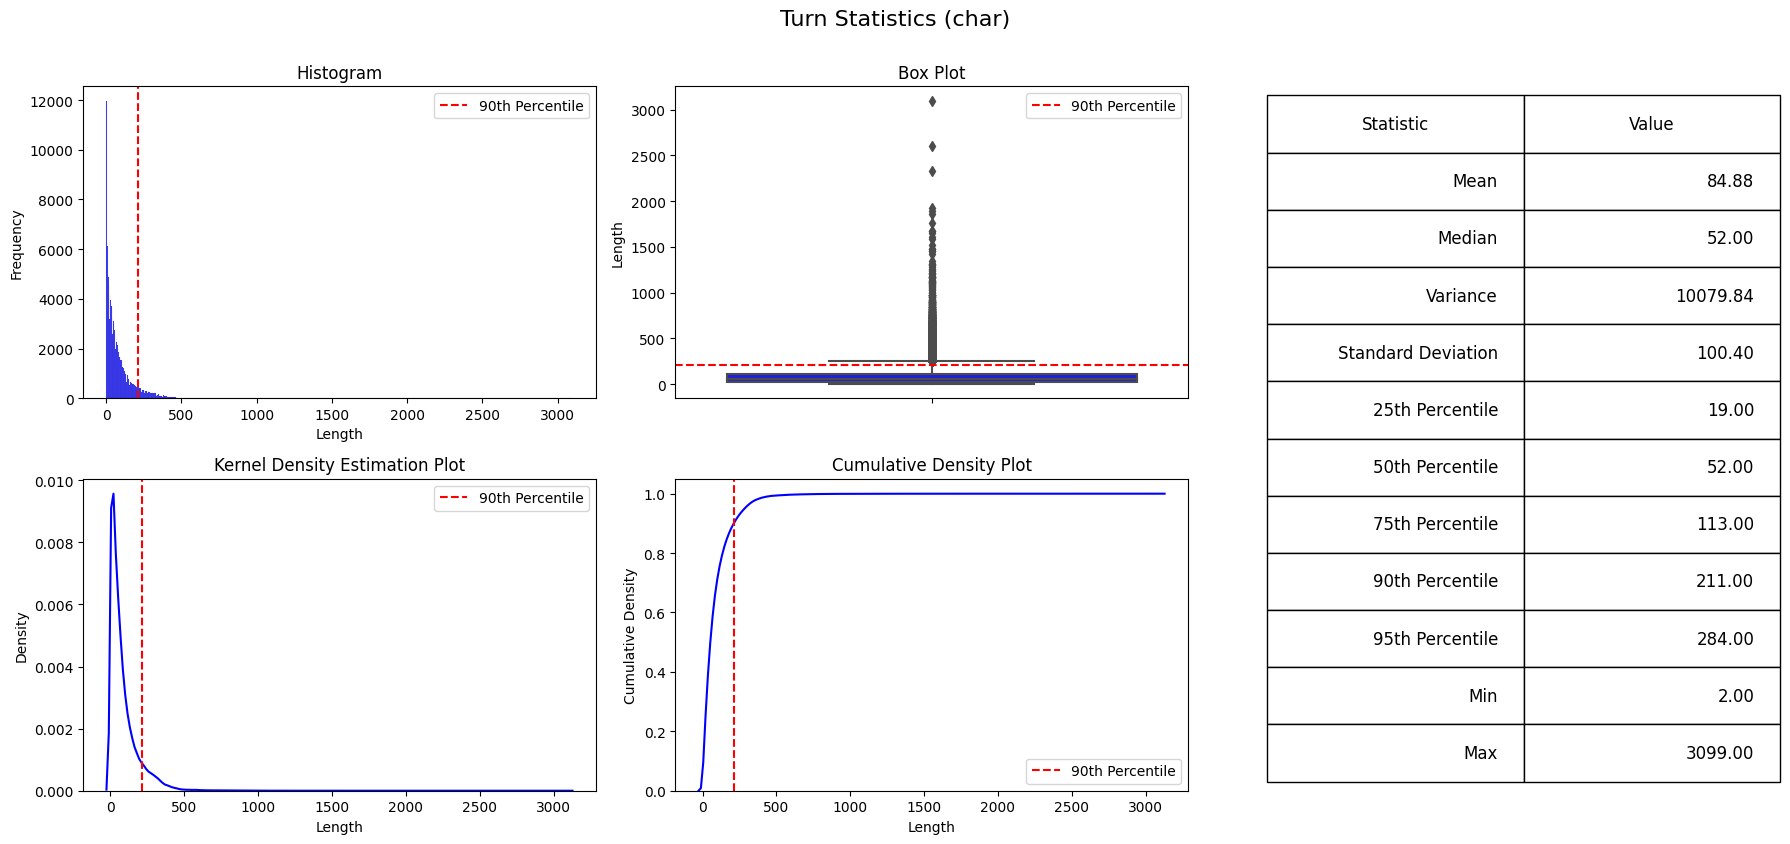

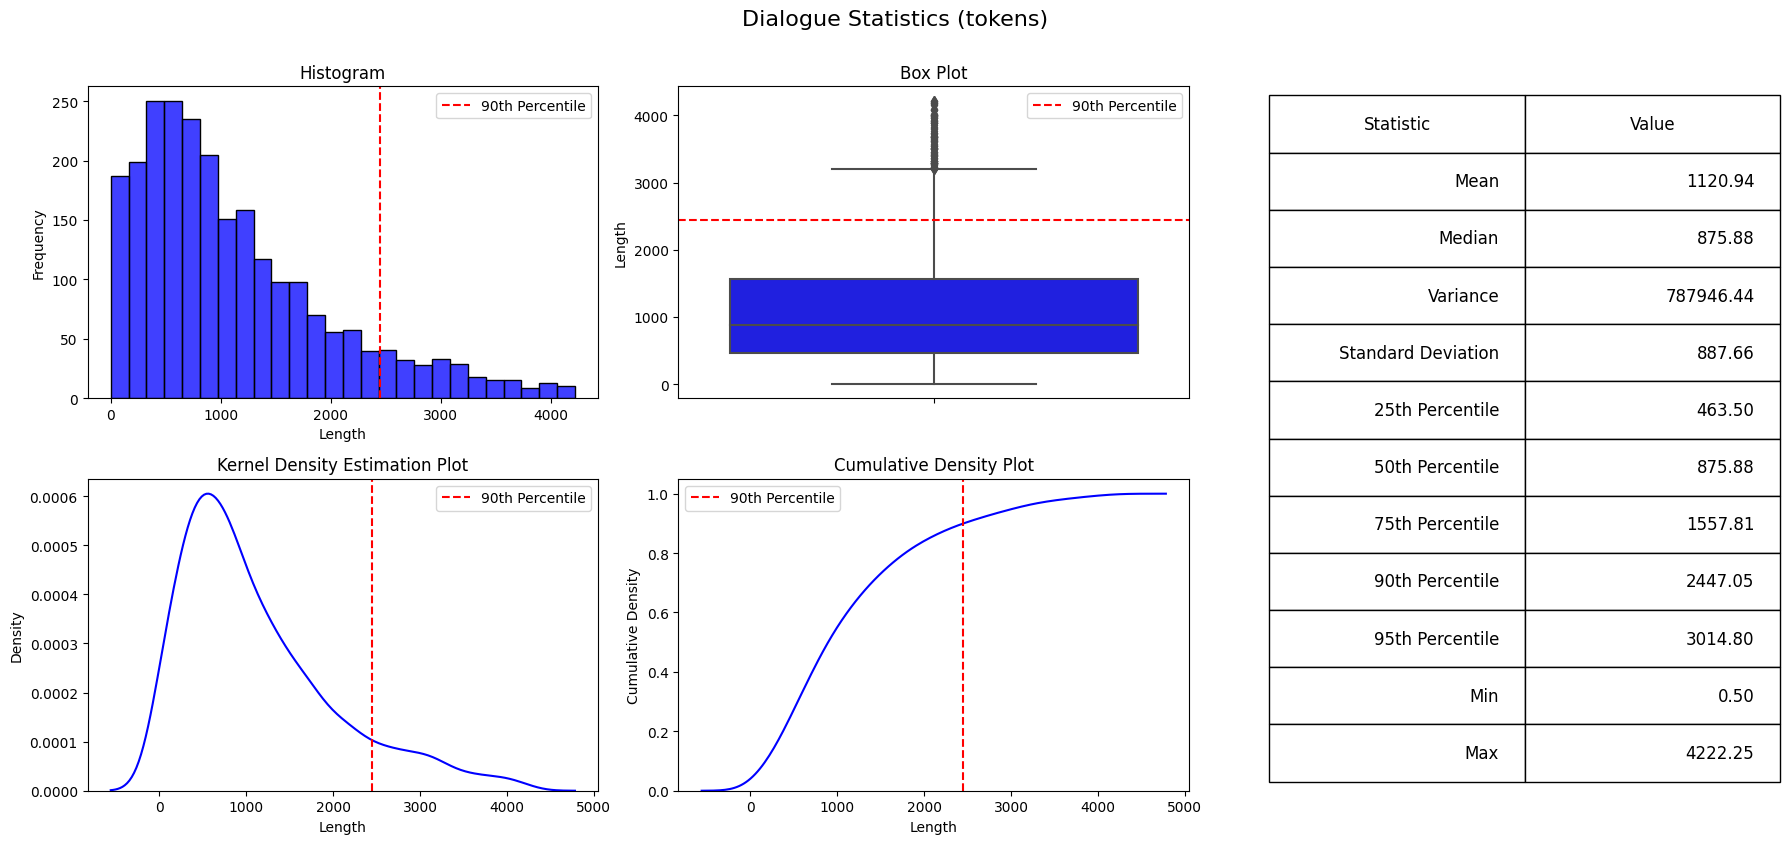

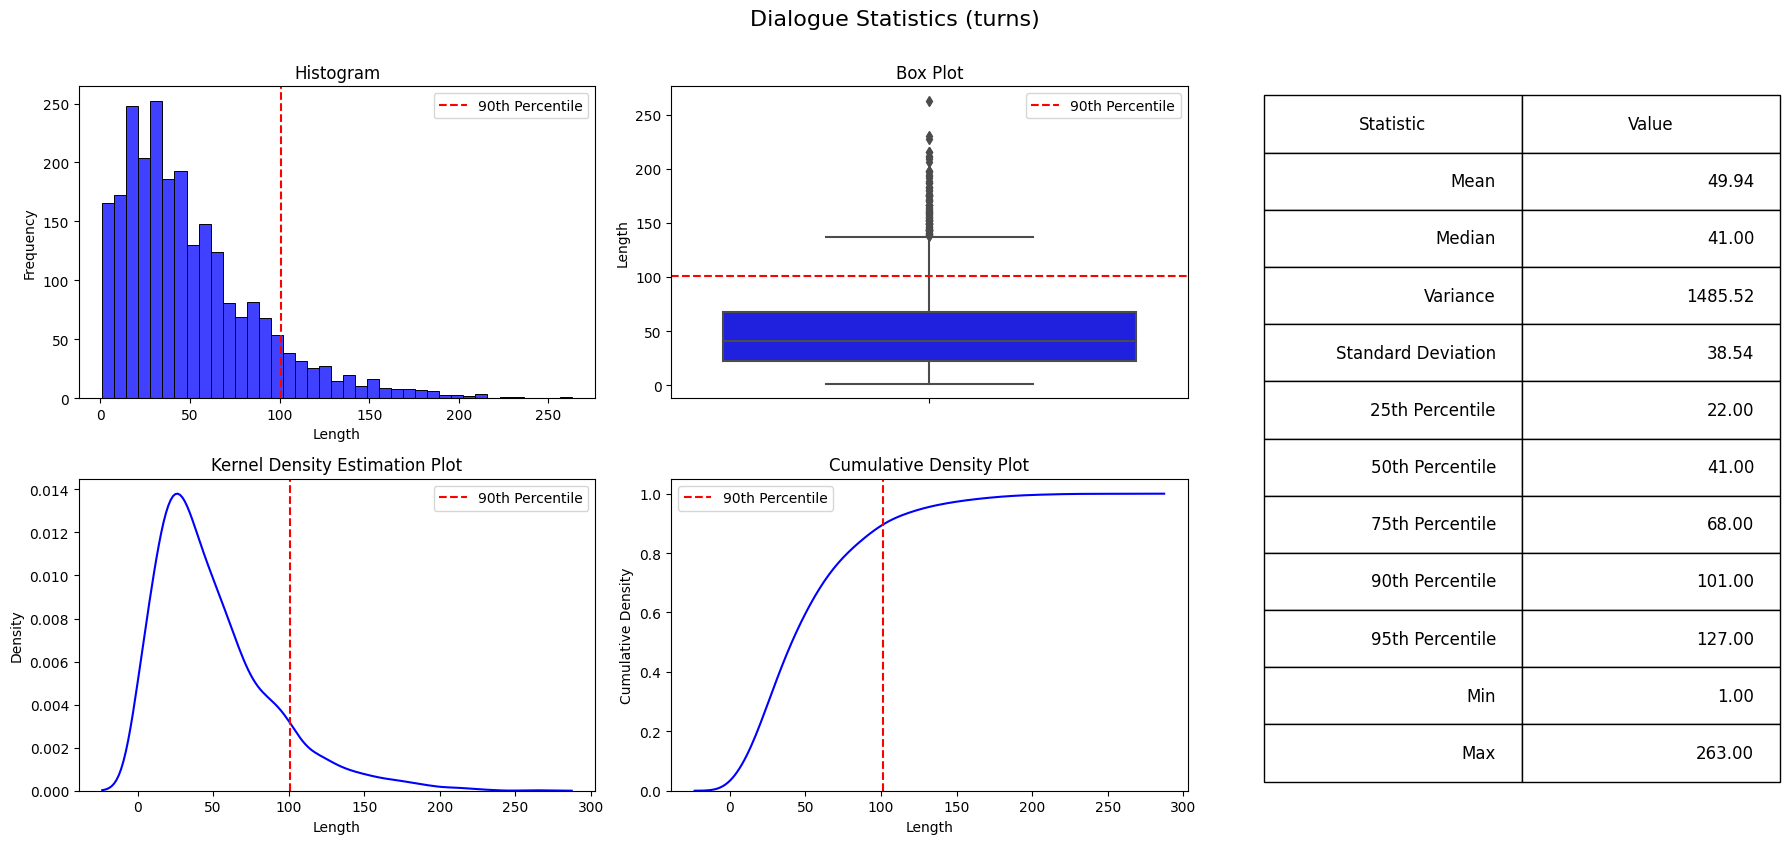

In [4]:
from data import get_DYDA, get_SWDA, get_KPN
from plot_distributions import array_statistics

train, test = get_KPN()
# train, test = get_SWDA()

turn_lengths = []
for dialogue in train[0]:
    for turn in dialogue:
        turn_length = len(turn)
        turn_lengths.append(turn_length)


dialogue_lengths = []
for dialogue in train[0]:
    concat_dialogue = "[SEP]".join(dialogue)
    dialogue_lengths.append(len(concat_dialogue) / 4)

dialogue_lengths_turns = []
for dialogue in train[0]:
    dialogue_lengths_turns.append(len(dialogue))

_ = array_statistics(turn_lengths, "Turn Statistics (char)")
_ = array_statistics(dialogue_lengths, "Dialogue Statistics (tokens)")
_ = array_statistics(dialogue_lengths_turns, "Dialogue Statistics (turns)")

In [6]:
len(train[0])

2414